# Process the output of the simulation

(This can be required if the sensitivity curve does not form a single connected (but possibly open) path.)

List the currently-installed packages (for reproducibility).

In [1]:
]st

Status `~/Documents/Research/Projects/SensCalc/Code/SensMC/Project.toml`
  [864edb3b] DataStructures v0.18.13
⌃ [31c24e10] Distributions v0.25.86
⌃ [e9467ef8] GLMakie v0.8.2
⌃ [5c1252a2] GeometryBasics v0.4.6
  [7073ff75] IJulia v1.24.0
⌃ [682c06a0] JSON v0.21.3
  [3f54b04b] LorentzVectors v0.4.3
  [ea0cff06] MDBM v0.1.6 `https://github.com/JLTastet/MDBM.jl#3788144`
⌅ [ee78f7c6] Makie v0.19.2
  [c03570c3] Memoize v0.4.4
  [e1d29d7a] Missings v1.1.0
  [3b2b4ff1] Multisets v0.4.4
⌃ [bac558e1] OrderedCollections v1.4.1
  [c46f51b8] ProfileView v1.7.1
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.1
⌃ [f2b01f46] Roots v2.0.10
⌃ [90137ffa] StaticArrays v1.5.18
⌅ [2913bbd2] StatsBase v0.33.21
  [8ba89e20] Distributed
  [37e2e46d] LinearAlgebra
  [1a1011a3] SharedArrays
Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


Include the snapshots of the relevant scripts (once again for reproducibility).

In [2]:
include("$(@__DIR__)/../lib/IncludeAll.jl");
include("$(@__DIR__)/../scripts/GenerateEvents.jl");
include("$(@__DIR__)/../scripts/ScanSensitivity.jl");

  Activating project at `~/Documents/Research/Projects/SensCalc/Code/SensMC`


In [3]:
data_dir = "$(@__DIR__)/../tables/sensitivity/MATHUSLA";

In [4]:
using DataFrames
using CSV
using Printf
using PyPlot
PyPlot.svg(true)
using Random
Random.seed!(25269);

In [5]:
function read_sensitivity(root, name)
    df_sol = CSV.read(joinpath(root, "$(name).csv"), DataFrame)
    df_ct  = CSV.read(joinpath(root, "$(name)_connection.csv"), DataFrame)
    edges = tuple.(df_ct[:,1], df_ct[:,2]);
    open_loops, closed_loops = find_loops(edges)
    curves = [(df_sol[perm,1], df_sol[perm,2]) for perm in vcat(open_loops, closed_loops)]
end

read_sensitivity (generic function with 1 method)

Plot the sensitivity along with the one obtained by Maksym, as a last cross-check.

In [6]:
function make_plot(; title="", xlabel=L"m_S\;[\mathrm{GeV}]", ylabel=L"\theta^2", figsize=(6.4, 4.8), grid=true)
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_yscale("log")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel);
    if grid
        ax.grid(color="gray", linestyle=":")
    end
    ax.autoscale()
    ax.set_title(title, fontsize=10)
    fig, ax
end

make_plot (generic function with 1 method)

In [7]:
function plot_sensitivity!(ax, root, name; label="", square=false, style...)
    curves = read_sensitivity(root, name)
    xs, ys = [], []
    for (i, curve) in enumerate(curves)
        lb = if i == 1; label else; "" end
        x, y = curve
        y = square ? y .^2 : y
        ax.plot(x, y, label=lb; style...)
        push!(xs, x)
        push!(ys, y)
    end
    xs, ys
end

plot_sensitivity! (generic function with 1 method)

In [8]:
function plot_reference_sensitivity!(ax, root, name;
        header=["mS", "signal_scale"], square=false, linewidth=1, style...)
    df = CSV.read(joinpath(root, name), DataFrame, header=header)
    y = square ? df[:,2] .^2 : df[:,2]
    ax.plot(df[:,1], y; linewidth=linewidth, style...)
end

plot_reference_sensitivity! (generic function with 1 method)

In [9]:
function plot_excluded_region!(ax, root, name;
        header=["mS", "signal_scale"], square=false, linewidth=1, style...)
    df = CSV.read(joinpath(root, name), DataFrame, header=header)
    y = square ? df[:,2] .^2 : df[:,2]
    ax.plot(df[:,1], y; color="black", linewidth=linewidth, style...)
    ax.fill(df[:,1], y; color="lightgrey", style...)
end

plot_excluded_region! (generic function with 1 method)

#### Produce the plot for the paper

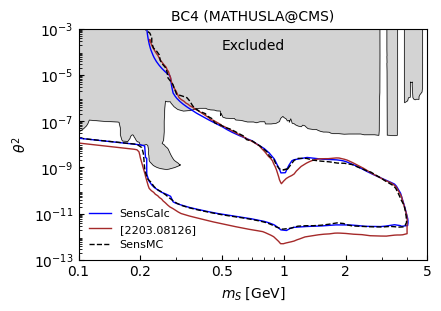

In [10]:
fig, ax = make_plot(title="BC4 (MATHUSLA@CMS)", figsize=(4.5,3), grid=false)
plot_excluded_region!(ax, joinpath(data_dir, ".."), "scalar-all-experiments.txt"; header=["mS", "theta"], linewidth=0.5)
plot_reference_sensitivity!(ax, data_dir, "Sensitivity_Scalar_at_MATHUSLA_BrhToSS=0._Nev=2.3_excl.dat"; header=["mS", "theta"], label="SensCalc", color="blue")
plot_reference_sensitivity!(ax, data_dir, "BC4-MATHUSLACMS.txt"; header=["mS", "theta"], label="[2203.08126]", color="brown")
mS, θ² = plot_sensitivity!(ax, data_dir, "MATHUSLA_scalar_sensitivity_CL90", label="SensMC", color="black", linestyle="--", square=true, linewidth=1)
ax.set_xscale("log")
ax.autoscale()
ax.set_xlim(left=0.1, right=5)
ax.set_ylim(top=1e-3, bottom=1e-13)
xticks = [0.1, 0.2, 0.5, 1, 2, 5]
ax.set_xticks(xticks)
ax.set_xticklabels([@sprintf("%.1g", x) for x in xticks])
ax.legend(loc="lower left", frameon=false, fontsize=8)
ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))
ax.tick_params(axis="both", which="both", direction="in")
#ax.text(0.83, 0.61, "CL = 0.9", fontsize=10, transform=ax.transAxes, ha="center", va="top")
ax.text(0.5, 0.96, "Excluded", fontsize=10, transform=ax.transAxes, ha="center", va="top")
nothing

In [11]:
fig.savefig("$(@__DIR__)/../plots/MATHUSLA_scalar_sensitivity_CL90.pdf", bbox_inches="tight")

#### Process and save the actual sensitivity curve

Extract the relevant loop(s).

In [12]:
mS

3-element Vector{Any}:
 [1.0444564159520908, 0.9911651626140505]
 [1.0444564159520908, 0.9911651626140505, 0.9502161191835193, 0.9165333481180901, 0.8936445815925262, 0.8493506076297634, 0.8372773344339982, 0.8013332877675993, 0.7716019830156984, 0.7370513342097953  …  0.24014898561070408, 0.2320717375892454, 0.22747694980721445, 0.22741052368757173, 0.22248052295173132, 0.21338764690018552, 0.2087229555695945, 0.20862704827855943, 0.20862704140039412, 0.20862704139891403]
 [1.0444564159520908, 1.0826599905532928, 1.1251542587057681, 1.1746412030292788, 1.2866217015693489, 1.3918944201213534, 1.5183327585570876, 1.6573456277236058, 1.6718428253076736, 1.8234609503707195  …  0.20326582972659532, 0.1924385631162271, 0.19027113255407085, 0.1747604283595366, 0.1605656525104205, 0.14747932609088782, 0.1354720040975265, 0.12444655921251424, 0.11431404515579531, 0.10506329351025953]

In [13]:
print([length(piece) for piece in mS])

[2, 48, 89]

The array looks like it isn’t connected well due to noise. Since there are only a few pieces, let’s connect them by hand. To this end, let’s drop the small loop and connect the big pieces together.

In [14]:
zip(mS[2], θ²[2]) |> collect

48-element Vector{Tuple{Float64, Float64}}:
 (1.0444564159520908, 8.456922572492747e-10)
 (0.9911651626140505, 7.831594936238133e-10)
 (0.9502161191835193, 8.685363004858717e-10)
 (0.9165333481180901, 1.3567779725700506e-9)
 (0.8936445815925262, 2.280269935645078e-9)
 (0.8493506076297634, 3.0942495812116686e-9)
 (0.8372773344339982, 4.320481277741905e-9)
 (0.8013332877675993, 6.01912575713078e-9)
 (0.7716019830156984, 8.046792042700437e-9)
 (0.7370513342097953, 1.0456436663273836e-8)
 (0.7034200641110223, 1.3873140480051108e-8)
 (0.658403537764417, 1.5945835875346406e-8)
 (0.639333094000464, 2.2415773374736512e-8)
 ⋮
 (0.2501765378541941, 4.237987410289101e-5)
 (0.24739178087981956, 7.476614415680034e-5)
 (0.24014898561070408, 0.00010754974606583949)
 (0.2320717375892454, 0.0001457706071289872)
 (0.22747694980721445, 0.00023713737035337208)
 (0.22741052368757173, 0.00042169070954866023)
 (0.22248052295173132, 0.0006508219815981188)
 (0.21338764690018552, 0.0008677500432849472)
 (0.2087

In [15]:
zip(mS[3], θ²[3]) |> collect

89-element Vector{Tuple{Float64, Float64}}:
 (1.0444564159520908, 8.456922572492747e-10)
 (1.0826599905532928, 1.3232042343962383e-9)
 (1.1251542587057681, 2.043999323991166e-9)
 (1.1746412030292788, 2.4553289348597763e-9)
 (1.2866217015693489, 2.458559505890045e-9)
 (1.3918944201213534, 2.049066121919122e-9)
 (1.5183327585570876, 1.8628111631735213e-9)
 (1.6573456277236058, 1.7481020948580456e-9)
 (1.6718428253076736, 1.7317502484882098e-9)
 (1.8234609503707195, 1.537561769979286e-9)
 (1.9726962463750104, 1.5056859982692068e-9)
 (2.154759522749904, 1.3187506503405004e-9)
 (2.31051878268781, 1.0013832161538337e-9)
 ⋮
 (0.20820977702005933, 2.369854354343471e-9)
 (0.20678650072808147, 4.191830031964121e-9)
 (0.20326582972659532, 7.220900341250721e-9)
 (0.1924385631162271, 9.962613101922055e-9)
 (0.19027113255407085, 1.0063140483998996e-8)
 (0.1747604283595366, 1.0958995825924728e-8)
 (0.1605656525104205, 1.1873696630486266e-8)
 (0.14747932609088782, 1.2826849342168666e-8)
 (0.1354720040

Create a data frame containing the curve.

In [16]:
df = DataFrame(
    mS = vcat(reverse(mS[3]), mS[2]),
    theta2 = vcat(reverse(θ²[3]), θ²[2])
)

Row,mS,theta2
,Float64,Float64
1,0.105063,1.7752e-8
2,0.114314,1.62601e-8
3,0.124447,1.49902e-8
4,0.135472,1.38586e-8
5,0.147479,1.28268e-8
6,0.160566,1.18737e-8
7,0.17476,1.0959e-8
8,0.190271,1.00631e-8
9,0.192439,9.96261e-9


Let’s check that it plots correctly.

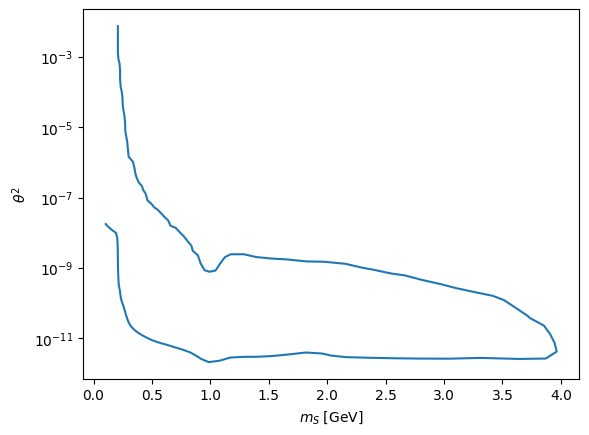

In [17]:
plt.plot(df.mS, df.theta2)
plt.yscale("log")
plt.xlabel(raw"$m_S\;[\mathrm{GeV}]$")
plt.ylabel(raw"$\theta^2$");

Looks good. Let’s save the final curve.

In [18]:
CSV.write(joinpath(data_dir, "MATHUSLA_scalar_sensitivity_curve_CL90.csv"), df)

"/Users/jl/Documents/Research/Projects/SensCalc/Code/SensMC/notebooks/../tables/sensitivity/MATHUSLA/MATHUSLA_scalar_sensitivity_curve_CL90.csv"